<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/Paul-Himyak-folder/Paul%20Himyak/main_25_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import re
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import concatenate, Embedding, Conv1D, Input, Dense, Dropout, BatchNormalization, Flatten , SpatialDropout1D, Reshape, RepeatVector, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
from tensorflow.keras import utils
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfad

import sklearn.metrics as skl_metrics




import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
dataset_url = "https://drive.google.com/uc?export=download&id=1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg"
#dataset_url = "https://docs.google.com/spreadsheets/d/1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg/edit?usp=share_link&ouid=113369956649761615778&rtpof=true&sd=true"
dataset_filename = "profpatolog_modified.xlsx"
#!wget -qc dataset_url -O dataset_filename
gdown.download(dataset_url, output=dataset_filename, quiet=True )


'profpatolog_modified.xlsx'

In [73]:
df = pd.read_excel("profpatolog_modified.xlsx")


In [74]:
#Удаляем случайные вбросы
df.drop([843, 851, 1022, 1024], inplace = True)

#Убираем пустые колонки
empty_columns = df.columns[df.isna().all()]
df.drop(empty_columns, inplace = True, axis = 1)

In [75]:
del df['Unnamed: 0']

In [76]:
FIELD_CLIENT_AGE = "КлиентВозраст"
FIELD_CLIENT_BIRTH_DAY = "КлиентДатаРождения"
FIELD_CLIENT_GENDER = "КлиентПол"
FIELD_CLIENT_GENDER_M = 0
FIELD_CLIENT_GENDER_F = 1
FIELD_CONCLUSION = "ЗаключениеМК"
FIELD_CONCLUSION_FIT = 1
FIELD_CONCLUSION_PART_FIT = 2
FIELD_CONCLUSION_NOT_FIT = 0

FIELD_DISPANSARY_GROUP = "ДиспансернаяГруппа"
FIELD_DISPANSARY_GROUP_I = 0
FIELD_DISPANSARY_GROUP_II = 1
FIELD_DISPANSARY_GROUP_III = 2
FIELD_DISPANSARY_GROUP_OTHER = 3

FIELD_HARMFUL_FACTORS = "ВредныеФакторы"


FIELD_NEW_AGE_CATEGORY = "ВозрастКатегория"
FIELD_NEW_MKBS = "mkbs"

FIELD_CLIENT_PROFESSION = "Профессия"
FIELD_NEW_CLIENT_PROFESSION = "Profession"
FIELD_NEW_CLIENT_ADDITIONS = "Дополнения сводные"

In [77]:
additions_df = df.filter(regex="(?i)Дополнение_Значение$")

In [78]:
df[FIELD_NEW_CLIENT_ADDITIONS] = additions_df.apply(lambda row: ",".join(row.dropna().astype("str")), axis=1)

In [79]:
df = df.loc[:, ~df.columns.str.contains('Дополнение_Значение', case=False)]


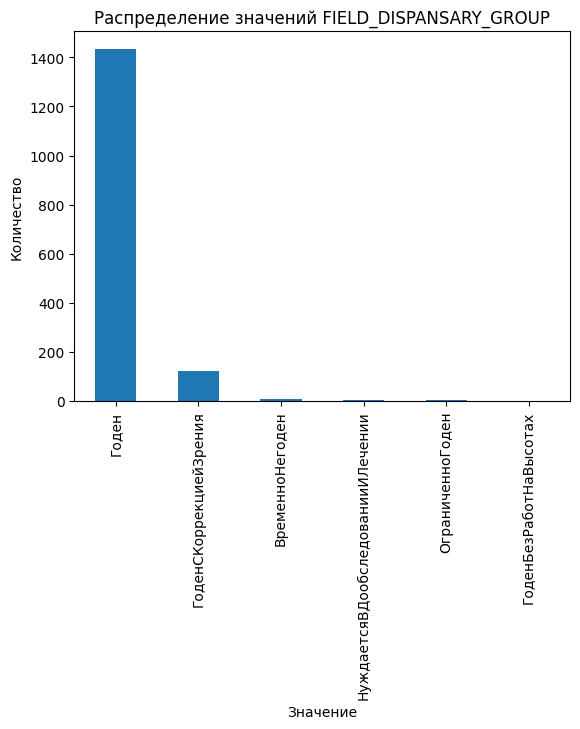

In [80]:
df[FIELD_CONCLUSION].value_counts().plot(kind='bar')

# Настраиваем параметры графика
plt.title('Распределение значений FIELD_DISPANSARY_GROUP')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

In [81]:
from datetime import datetime
class MyUtils:
  conclusion_map = {FIELD_CONCLUSION_FIT:'Годен', FIELD_CONCLUSION_PART_FIT:"Частично годен", FIELD_CONCLUSION_NOT_FIT: 'Негоден'}
  @classmethod
  def conclusion_labels(cls):
    return  [cls.conclusion_map[k] for k in sorted(cls.conclusion_map)]

  @classmethod
  def resolve_conclusion_map(cls,x):
    return cls.conclusion_map[x]
  @staticmethod  
  # Определяем функцию для расчета возраста на основе даты
  def resolve_birthdate_to_age(date):
    current_year = pd.Timestamp.now().year
    age = current_year - date.year
    return age
  def resolve_genger(x):
    if x == 'Мужской':
        return FIELD_CLIENT_GENDER_M
    elif x == 'Женский':
        return FIELD_CLIENT_GENDER_F
    else:
        return None

  def resolve_conclusion_binary(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_conclusion(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      elif "Негоден" in arg:
        return FIELD_CONCLUSION_NOT_FIT
      elif "Годен" in arg:
        return FIELD_CONCLUSION_PART_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_dispansary_group(arg):
    try:
      if arg == "I":
        return FIELD_DISPANSARY_GROUP_I
      elif arg == "II":
        return FIELD_DISPANSARY_GROUP_II
      elif "III" in arg :
        return FIELD_DISPANSARY_GROUP_III
      else:
        return FIELD_DISPANSARY_GROUP_OTHER
    except (TypeError):
        return None
  def resolve_age_to_category(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [82]:
# Преобразование заключения в цифру
df[FIELD_CONCLUSION] = df[FIELD_CONCLUSION].apply(lambda x: MyUtils.resolve_conclusion(x))

In [83]:

# Разделим данные по значениям поля FIELD_CONCLUSION
fit = df[df[FIELD_CONCLUSION] == FIELD_CONCLUSION_FIT]
not_fit = df[df[FIELD_CONCLUSION] == FIELD_CONCLUSION_NOT_FIT]
part_fit = df[df[FIELD_CONCLUSION] == FIELD_CONCLUSION_PART_FIT]

# Увеличим меньшие классы до размера большего класса
n_samples = len(fit)
not_fit_upsampled = resample(not_fit, replace=True, n_samples=n_samples, random_state=42)
part_fit_upsampled = resample(part_fit, replace=True, n_samples=n_samples, random_state=42)

# Объединим данные и перемешаем их
df_balanced = pd.concat([fit, not_fit_upsampled, part_fit_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)


In [84]:
# Преобразование колонки возраста в цифровой вид
df[FIELD_CLIENT_AGE] = df[FIELD_CLIENT_BIRTH_DAY].apply(MyUtils.resolve_birthdate_to_age)

# разделение возраста на категории
df[FIELD_NEW_AGE_CATEGORY] = df[FIELD_CLIENT_AGE].apply(MyUtils.resolve_age_to_category)

# Пол в цифру
df[FIELD_CLIENT_GENDER] = df[FIELD_CLIENT_GENDER].apply(lambda x: MyUtils.resolve_genger(x) if pd.notnull(x) else x)

# Удалим неиспользованные колонки
del df[FIELD_CLIENT_BIRTH_DAY]
del  df[FIELD_CLIENT_AGE]

In [85]:
#Преобразование диспансерных групп в цифру
df[FIELD_DISPANSARY_GROUP] = df[FIELD_DISPANSARY_GROUP].apply(MyUtils.resolve_dispansary_group)

In [86]:
# Все колонки МКБ10
mkb_columns = df.filter(regex="(?i)МКБ10").columns

#Решил заменить пустые колонки на Z00.0
df[mkb_columns] = df[mkb_columns].fillna(value='Z00.0')

# объединяем значения из нескольких столбцов в одну колонку, удаляем дубликаты, чтоб уменьшить разреженность 
#df['mkb'] = df.apply(lambda row: list(set([row[mkb_col_name] for mkb_col_name in mkb_columns if not pd.isna(row[mkb_col_name]) ])), axis=1)
df[FIELD_NEW_MKBS] = df.apply(lambda row: list(set([row[mkb_col_name] for mkb_col_name in mkb_columns])), axis=1)

# исключаем из фрейма все МКБ поскольку теперь у нас есть одна общая mkbs
df = df.loc[:, ~df.columns.str.contains('мкб10', case=False)]



In [87]:
# разделяем факторы по одному значению
df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")

<ipython-input-87-593652ce6884>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")


In [88]:
df.dropna(inplace = True)

<ipython-input-88-d1ada024d2eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [89]:
df[FIELD_HARMFUL_FACTORS]

0                [11.4]
1               [4.2.5]
2               [4.2.5]
3                [11.1]
4                [11.1]
             ...       
1960    [4.4, 4.5, 6.1]
1961    [4.4, 4.5, 6.1]
1962              [4.4]
1972          [3.1.8.2]
1973       [4.2.5, 6.1]
Name: ВредныеФакторы, Length: 1562, dtype: object

Подготавливаю все однозначные цифровые данные в OHE

In [90]:
# Объединяю категориальные значения в OHE
df_ohe  = pd.get_dummies(df[[FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY]],  columns = [FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY] )
xTrain0 = df_ohe.values
xTrain0.shape


(1562, 16)

In [91]:
df[FIELD_CONCLUSION].value_counts()

1.0    1428
2.0     126
0.0       8
Name: ЗаключениеМК, dtype: int64

In [92]:
yTrain =  pd.get_dummies(df[FIELD_CONCLUSION]).values

In [93]:
FIELD_CONCLUSION_PART_FIT

2

In [94]:
Y_CLASSES = yTrain.shape[1]
Y_CLASSES

3

In [95]:
yTrain.shape

(1562, 3)

Поскольку теперь mkb колонка одна, то пришла мысль поработать с ней как эмбедингом

In [96]:
df[FIELD_NEW_MKBS].explode().unique()

array(['Z00.0', 'I11.9', 'H52.1', 'H52.2', 'H53.0', 'K29.3', 'I70',
       'H90.5', 'G90.9', 'H52.0', 'S68.2', 'N60.2', 'E11.9', 'K29.6',
       'M42.1', 'D25', 'I69.4', 'N83.2', 'H90.3', 'K44.9', 'N80.0',
       'G99.0', 'G12.1', 'K81.9', 'H11.0', 'G25.0', 'K26.9', 'K86.1',
       'H91.1', 'I67.2', 'H74.1', 'N28.1', 'L40.0', 'I83.9', 'H93.0',
       'D25.9', 'I25.8', 'K80.5', 'F06.6', 'K40.9', 'E11.8', 'E10.9',
       'T94.0', 'F10.7', 'D35.2', 'L20.8', 'K29.5', 'H50.9', 'K80.2',
       'I25.2', 'Q12.0', 'S51.9', 'F06.7', 'H25.0', 'I66.9', 'I67.9',
       'K29.8', 'T90.4', 'H40.1', 'H90.4', 'F41.0', 'R25.1', 'K29.7',
       'H47.2', 'J33.0', 'H66.1', 'K26.7', 'H02.4', 'I49.9', 'H01.0',
       'F98.5', 'I49.8', 'J45.8', 'H35.0', 'H17.1', 'J30.1', 'F07.0',
       'G58.9', 'J37.0', 'H25.1', 'I25.9', 'K82.9', 'J45.9', 'G90.8',
       'K29.4'], dtype=object)

In [97]:
tokenizer_mkb = Tokenizer()
tokenizer_mkb.fit_on_texts(np.array(df[FIELD_NEW_MKBS]))
mkb_vocab_size = len(tokenizer_mkb.word_index) + 1
mkb_vocab_size


86

In [98]:
xMkbIndexed = tokenizer_mkb.texts_to_sequences(df[FIELD_NEW_MKBS])

In [99]:
np_len = np.vectorize(len)
mkb_max_len = np_len(xMkbIndexed).max()
mkb_max_len

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2336: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]


5

In [100]:
xMkbIndexedPadded = pad_sequences(xMkbIndexed, maxlen=mkb_max_len, padding='post')
xTrainMkb = xMkbIndexedPadded

In [101]:
xMkbIndexedPadded.shape

(1562, 5)

вредные факторы тоже токенизировал для дальнейшего использования его в эмбединге

In [102]:
#tokenizing harm codes
tokenizer_harmfull = Tokenizer()
tokenizer_harmfull.fit_on_texts(df[FIELD_HARMFUL_FACTORS])
harmfull_vocab_size = len(tokenizer_harmfull.word_index) + 1
xTrainHarmfulIndexes = tokenizer_harmfull.texts_to_sequences(df[FIELD_HARMFUL_FACTORS])
harm_max_len = np_len(xTrainHarmfulIndexes).max()
harm_max_len

13

In [103]:
xTrainHarmfulIndexesPadded = pad_sequences(xTrainHarmfulIndexes, maxlen=harm_max_len, padding='post')
xTrainHarmFull = xTrainHarmfulIndexesPadded
xTrainHarmFull.shape

(1562, 13)

Профессии токенизировал тоже будут эмбеддингами

In [104]:
maxWordsCount = 1000 
tokenizer_prof = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_prof.fit_on_texts(df[FIELD_CLIENT_PROFESSION]) 


In [105]:
prof_vocab_size = len(tokenizer_prof.word_index) + 1
prof_vocab_size


514

In [106]:
xTrainProfIndexed = tokenizer_prof.texts_to_sequences(df[FIELD_CLIENT_PROFESSION])
prof_max_len = np_len(xTrainProfIndexed).max()
prof_max_len
xTrainProfIndexedPadded = pad_sequences(xTrainProfIndexed, maxlen=prof_max_len, padding='post')
xTrainProf = xTrainProfIndexedPadded
xTrainProf.shape



(1562, 12)

Дополнительные комментарии специалистов

In [107]:
tokenizer_additions = Tokenizer(num_words=1000, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer_additions.fit_on_texts(df[FIELD_NEW_CLIENT_ADDITIONS]) 

In [108]:
additions_vocab_size = len(tokenizer_additions.word_index) + 1
additions_vocab_size

1398

In [109]:
xTrainAdditionsIndexed = tokenizer_additions.texts_to_sequences(df[FIELD_NEW_CLIENT_ADDITIONS])
additions_max_len = np_len(xTrainAdditionsIndexed).max()
additions_max_len
xTrainAdditionsIndexedPadded = pad_sequences(xTrainProfIndexed, maxlen=additions_max_len, padding='post')
xTrainAdditions = xTrainAdditionsIndexedPadded
xTrainAdditions.shape

(1562, 109)

In [110]:
x_train, x_test, x_train_mkb, x_test_mkb, x_train_harmfull, x_test_harmfull, x_train_prof, x_test_prof, x_train_additions, x_test_additions,  y_train, y_test = train_test_split(xTrain0,
                                                                                                              xTrainMkb,
                                                                                                              xTrainHarmFull,
                                                                                                              xTrainProf,
                                                                                                              xTrainAdditions,                                                                                                              
                                                                                                              yTrain, 
                                                                                                              test_size=0.2,
                                                                                                              shuffle = False)

In [111]:
from os import name
# На этот вход подаются все OHE
input0 = Input((x_train.shape[1], ), name="OHE")
# Сюда подаются mkb в виде последовательности токенов , поскольку они уже объединины в одой колонке
input_mkb = Input((x_train_mkb.shape[1],), name="MKB")
# Сюда подаются вредные факторы тоже аналогично мкб , как будто это предложение из токенов 
input_harmfull = Input((x_train_harmfull.shape[1],), name="harm")
# Сюда подаются профессии , тоже как предложение токенов
input_prof = Input((x_train_prof.shape[1],), name="prof")
# Дополнения от специалистов
input_additions = Input((x_train_additions.shape[1],), name="additions")

In [112]:
print(
    input_harmfull.shape,
    input_prof.shape,
    input_additions.shape
)


(None, 13) (None, 12) (None, 109)


In [113]:
x_train_mkb[:3,:]

array([[1, 0, 0, 0, 0],
       [1, 2, 0, 0, 0],
       [3, 1, 0, 0, 0]], dtype=int32)

In [114]:
def create_model1(input0, input_mkb, input_harmfull, input_prof):
  x0 = BatchNormalization()(input0)
  x0 = Dense(1024, activation='relu') (x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(768, activation='sigmoid')(x0)
  x0 = BatchNormalization()(x0)
  x0 = Dropout(0.3)(x0)
  x0 = Dense(512, activation='sigmoid')(x0)

  x1 = Embedding(mkb_vocab_size, 128,  input_length = mkb_max_len)(input_mkb)
  x1 = SpatialDropout1D(0.2)(x1)
  x1 = Dense(100, activation = 'sigmoid')(x1)
  #x1 = Flatten()(x1)

  x2 = Embedding(harmfull_vocab_size, 128, input_length = harm_max_len)(input_harmfull)
  x2 = SpatialDropout1D(0.2)(x2)
  x2 = Dense(100, activation = 'sigmoid')(x2)
  #x2 = Flatten()(x2)

 # x3 = Embedding(prof_vocab_size, 256, input_length = prof_max_len)(input_prof)
 # x3 = SpatialDropout1D(0.2)(x3)
  x3 = Dense(100, activation = 'sigmoid')(input_prof)
  x3 = Reshape((1, 100))(x3)

  #x3 = Flatten()(x3)

  x_ = concatenate([x1, x2, x3], axis = -2)
  x_ = Flatten()(x_)
  x = concatenate([x0, x_])


  x = Dense(800, activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(Y_CLASSES, activation='softmax')(x)

  return Model((input0, input_mkb, input_harmfull, input_prof), x )


Модель 1

In [115]:
#model1 = create_model1(input0, input_mkb, input_harmfull, input_prof)
#utils.plot_model(model1, dpi=60, show_shapes = True)


In [116]:
def f1_score_keras(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Округление предсказанных значений до 0 или 1
    return skl_metrics.f1_score(y_true, y_pred)

f1score = tfad.metrics.F1Score(num_classes=Y_CLASSES)


In [117]:
#model1.compile(optimizer = Adam(learning_rate = 1e-5), loss = keras_losses.categorical_crossentropy, metrics=['mae', 'accuracy'])

In [118]:

# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

In [119]:
#history = model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
#                    y_train,
#                    batch_size=32,
#                    epochs = 100,
#                    validation_split = 0.2,
#                    verbose = 1)

In [120]:
#model1.save("drive/MyDrive/prof_patolog/model1.h5")

In [121]:
#дообучение
#model1.compile(optimizer = Adam(learning_rate = 5e-6), loss = keras_losses.categorical_crossentropy, metrics=['mae', 'accuracy'])
#history = model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof], #model1.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof],
##                    y_train,
#                    batch_size=32,
#                    epochs = 50,
#                    validation_split = 0.2,
#                    verbose = 1)

In [122]:
#compare_sharp_loss(history, 10, 4)

Модель 2

In [123]:
x0 = BatchNormalization()(input0)
x0 = Dense(1024, activation='relu') (x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(768, activation='sigmoid')(x0)
x0 = BatchNormalization()(x0)
x0 = Dropout(0.3)(x0)
x0 = Dense(512, activation='sigmoid')(x0)

x1 = Embedding(mkb_vocab_size, 128, input_length = mkb_max_len)(input_mkb)
x1 = SpatialDropout1D(0.2)(x1)
x1 = Conv1D(128,3, activation = 'relu', padding='same')(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dense(256, activation = 'sigmoid')(x1)
#x1 = Flatten()(x1)

x2 = Embedding(harmfull_vocab_size, 128, input_length = harm_max_len)(input_harmfull)
x2 = SpatialDropout1D(0.2)(x2)
x2 = Conv1D(128,3, activation = 'relu', padding='same')(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dense(256, activation = 'relu')(x2)
#x2 = Flatten()(x2)

x3 = Embedding(prof_vocab_size, 256, input_length = prof_max_len)(input_prof)
x3 = SpatialDropout1D(0.2)(x3)
x3 = Conv1D(128,2, activation = 'relu', padding='same')(x3)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dense(256, activation = 'relu')(x3)
#x3 = Flatten()(x3)

x4 = Embedding(additions_vocab_size, 256, input_length = prof_max_len)(input_additions)
x4 = SpatialDropout1D(0.2)(x4)
x4 = Conv1D(128,2, activation = 'relu', padding='same')(x4)
x4 = GlobalMaxPooling1D()(x4)
x4 = Dense(256, activation = 'relu')(x4)
#x3 = Flatten()(x3)

x = concatenate([x0,x1, x2, x3, x4])
x = Dense(800, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(Y_CLASSES, activation='softmax')(x)

model2 =  Model((input0, input_mkb, input_harmfull, input_prof, input_additions), x )
model2.compile(optimizer = Adam(learning_rate = 1e-4), loss = keras_losses.mse, metrics=[keras_metrics.mae, f1score])


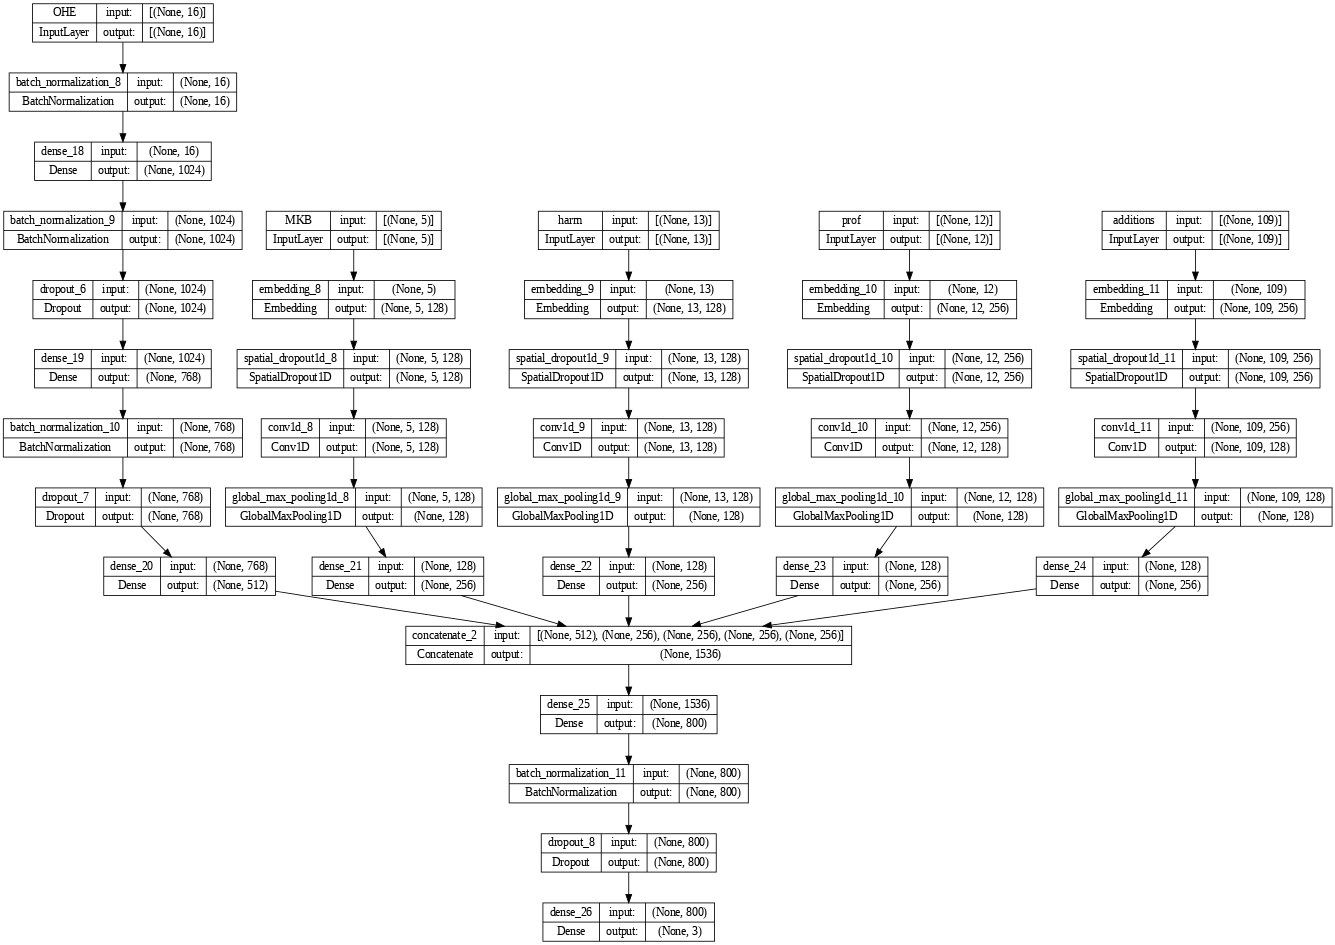

In [124]:
utils.plot_model(model2, dpi=60, show_shapes = True)


In [125]:
print(x_train.shape,x_train_mkb.shape, x_train_harmfull.shape, x_train_prof.shape, x_train_additions.shape)

(1249, 16) (1249, 5) (1249, 13) (1249, 12) (1249, 109)


In [126]:
history = model2.fit([x_train, x_train_mkb, x_train_harmfull, x_train_prof, x_train_additions],
                    y_train,
                    batch_size=32,
                    epochs = 70,
                    validation_split = 0.20,
                    verbose = 1)

Epoch 1/70
32/32 [==============================] - 7s 84ms/step - loss: 0.2394 - mean_absolute_error: 0.3632 - f1_score: 0.2839 - val_loss: 0.1194 - val_mean_absolute_error: 0.3119 - val_f1_score: 0.3158
Epoch 2/70
32/32 [==============================] - 3s 96ms/step - loss: 0.1706 - mean_absolute_error: 0.2707 - f1_score: 0.3594 - val_loss: 0.0893 - val_mean_absolute_error: 0.2513 - val_f1_score: 0.3158
Epoch 3/70
32/32 [==============================] - 4s 128ms/step - loss: 0.1537 - mean_absolute_error: 0.2360 - f1_score: 0.3235 - val_loss: 0.0741 - val_mean_absolute_error: 0.2063 - val_f1_score: 0.3158
Epoch 4/70
32/32 [==============================] - 4s 114ms/step - loss: 0.1394 - mean_absolute_error: 0.2087 - f1_score: 0.3633 - val_loss: 0.0711 - val_mean_absolute_error: 0.1905 - val_f1_score: 0.3158
Epoch 5/70
32/32 [==============================] - 4s 114ms/step - loss: 0.1365 - mean_absolute_error: 0.1978 - f1_score: 0.3606 - val_loss: 0.0743 - val_mean_absolute_error: 0.

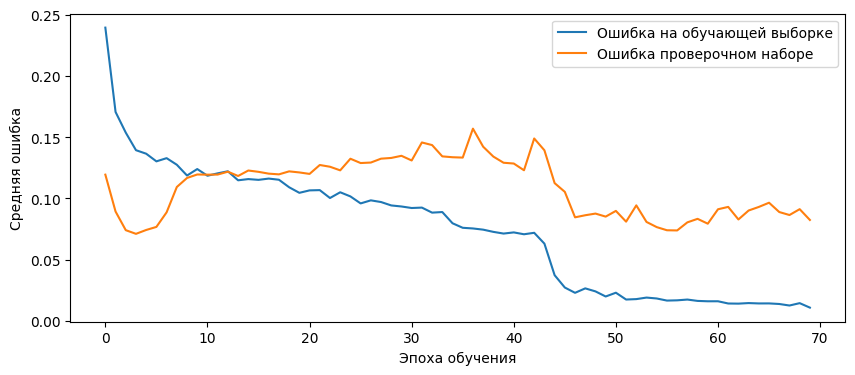

In [127]:
compare_sharp_loss(history, 10, 4)

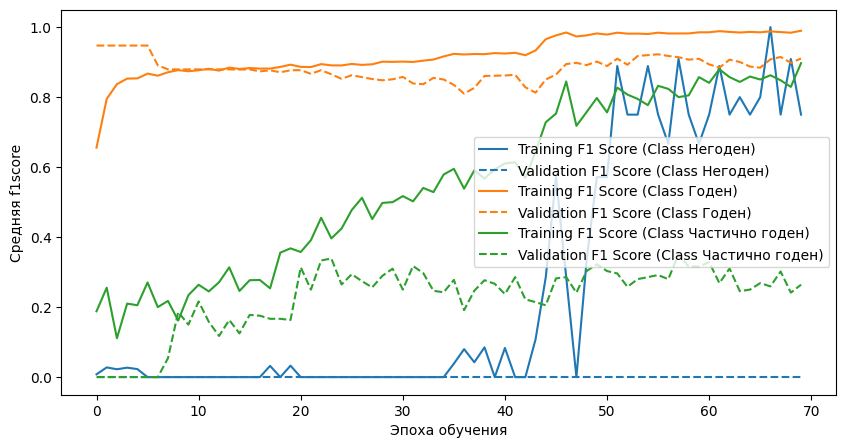

In [154]:
train_f1scores = np.array(history.history['f1_score'])
val_f1scores = np.array(history.history['val_f1_score'])
plt.figure(figsize=(10,5))

for class_idx in range(Y_CLASSES):
    color = f'C{class_idx}'
    plt.plot(train_f1scores[:, class_idx], color=color, linestyle = '-', label=f'Training F1 Score (Class {MyUtils.conclusion_map[class_idx]})')
    plt.plot(val_f1scores[:, class_idx], color=color, linestyle = '--',label=f'Validation F1 Score (Class {MyUtils.conclusion_map[class_idx]})')


plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя f1score')
plt.legend()
plt.show()

In [128]:
y_pred  = model2.predict((x_test, x_test_mkb, x_test_harmfull, x_test_prof, x_test_additions))


10/10 [==============================] - 0s 21ms/step


In [155]:
print(y_pred[0], '-' , y_test[0])


[1.02908336e-04 9.99894321e-01 2.77734875e-06] - [0 1 0]


In [156]:
y_pred_idx = np.argmax(y_pred, axis=1)
y_test_idx = np.argmax(y_test, axis=1)
df_result = pd.DataFrame({'pred': y_pred_idx, 'test': y_test_idx})
df_result['pred'] = df_result['pred'].apply(MyUtils.resolve_conclusion_map)
df_result['test'] = df_result['test'].apply(MyUtils.resolve_conclusion_map)
display(df_result)
num_wrong = 0
for pred, test in zip(y_pred_idx, y_test_idx):
    if pred != test:
        num_wrong += 1

percent_wrong = num_wrong / len(y_test_idx) * 100
print(f"Percent wrong: {percent_wrong:.2f}%")


,pred,test
0,Годен,Годен
1,Годен,Годен
2,Годен,Годен
3,Годен,Годен
4,Годен,Годен
...,...,...
308,Годен,Годен
309,Годен,Годен
310,Годен,Годен
311,Годен,Годен


Percent wrong: 10.54%


In [131]:
(df_result['pred'] != df_result['test']).sum()


33

In [157]:
# Подсчет общего количества значений в столбце test
total_values = df_result['test'].count()

# Подсчет количества несовпадений
num_mismatches = (df_result['pred'] != df_result['test']).sum()

# Подсчет процентного соотношения несовпадений
mismatch_percentage = (num_mismatches / total_values) * 100
mismatch_percentage


10.543130990415335

In [158]:
np.argmax(y_pred, axis = -1).shape

(313,)

In [159]:
np.argmax(y_test, axis = -1).shape

(313,)

In [160]:
cm = confusion_matrix(np.argmax(y_test, axis=-1),
                          np.argmax(y_pred, axis=-1),
                          normalize='true')

In [161]:
cm = np.around(cm, 1)

In [162]:
MyUtils.conclusion_labels()[np.argmax([1,0,0])]

'Негоден'

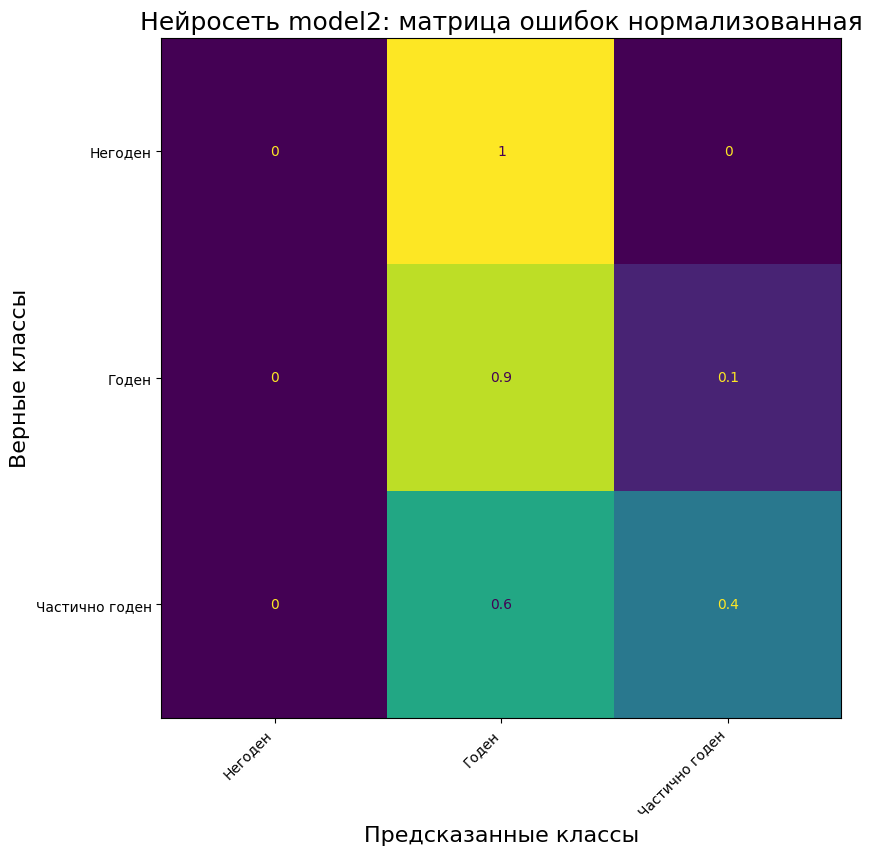

In [163]:

figsize = (10,10)
title = "model2"
# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MyUtils.conclusion_labels())
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
plt.show()    

In [139]:
# Подсчет матрицы ошибок
cm = confusion_matrix(y_test_idx, y_pred_idx)

# Подсчет количества верных предсказаний
num_correct = cm.diagonal().sum()

# Подсчет количества ошибочных предсказаний
num_mismatches = cm.sum() - num_correct

# Подсчет процентного соотношения несовпадений
mismatch_percentage = (num_mismatches / cm.sum()) * 100

# Вывод результата
print(f'Количество верных предсказаний: {num_correct}')
print(f'Количество ошибочных предсказаний: {num_mismatches}')
print(f'Процентное соотношение несовпадений: {mismatch_percentage:.2f}%')

Количество верных предсказаний: 280
Количество ошибочных предсказаний: 33
Процентное соотношение несовпадений: 10.54%


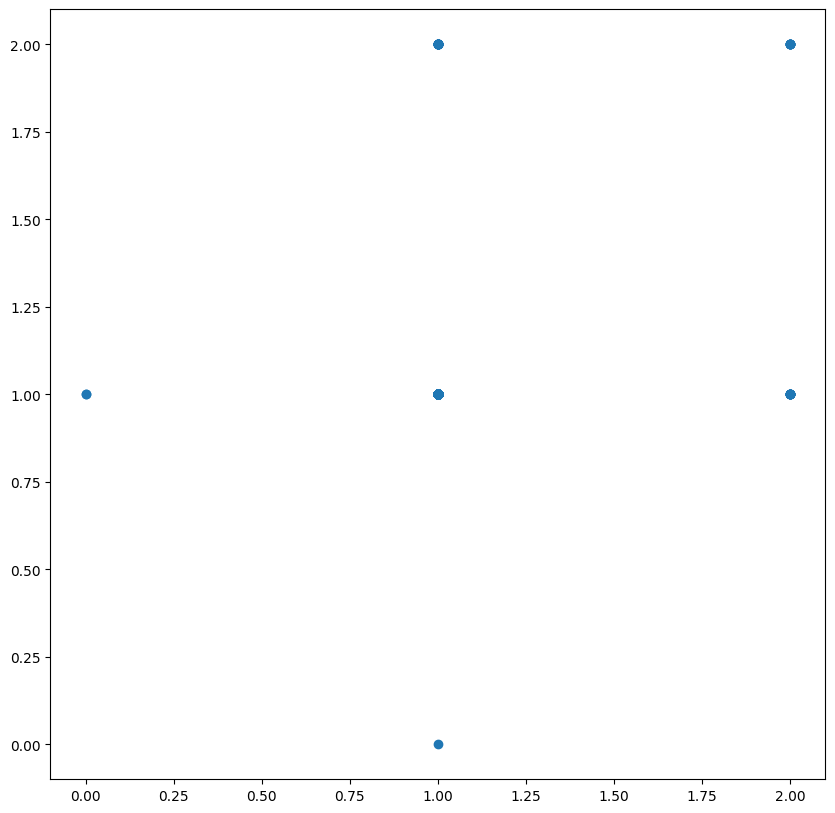

In [140]:
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(y_test_idx, y_pred_idx)

**Вывод**: Основная идея объединить МКБ в одну колонку и пройти по ней как по предложению через свертки, для выявления взаимосвязи между специалистами.

Результат слабоватый, возможно из-за слишком несбалансированнной базы
По этой же причине не стал обрабатывать основные текстовые поля, хотя была та же идея избавится от разрежения значений полей специалистов путём объединения текстов колонок в одну в виде текста с разбивкой на абзацы и заголовками  для каждого специалиста.
Если будет база со сбалансированными данными, возможно это будет уместно сделать 